In [1]:
import pandas as pd
import glob
import os
import json
import numpy as np
from  cycler import cycler
import fastplot
from collections import Counter, defaultdict
from statistics import mode
import re
import statsmodels.stats.proportion
import matplotlib.pyplot as plt


CYCLER_LINESPOINTS=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]) +
                    cycler('marker', ['o', 's', 'v', 'd', '^' ]))

CYCLER_LINES=(cycler('color', ['r', 'b', 'g', 'purple', 'c']) +
                    cycler('linestyle', ['-', '--', '-.', ':', (0, (3, 1, 1, 1)) ]))

PLOT_ARGS = {"style":"latex", "grid":True, "figsize":(4.25,2.5), "rcParams":{'text.latex.preamble': r'\usepackage{libertine}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,2.75), "rcParams":{'text.latex.preamble': r'\usepackage{libertine}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

BEFORE_STR = "\\emph{Before-Accept}"
AFTER_STR = "\\emph{After-Accept}"

TRANSLATE_CATEGORIES = {"Computers Electronics and Technology": "Computers and Technology",
                        "Business and Consumer Services": "Business and Services",
                        "Heavy Industry and Engineering": "Industry and Engineering"}

COUNTRY_TRAD={"it":"Italy", "fr":"France", "de":"Germany", "es":"Spain", "uk":"UK", "us": "US"}

%matplotlib inline

In [3]:
trackers = set( open("trackers-list.txt", "r").read().splitlines() )

similarweb_websites=defaultdict(set)
similarweb_websites['us'] = set(open("similarweb/USA.txt", "r" ).read().splitlines()) 
    

In [4]:
bad_domains=set("co.uk co.jp co.hu co.il com.au co.ve .co.in com.ec com.pk co.th co.nz com.br com.sg com.sa \
com.do co.za com.hk com.mx com.ly com.ua com.eg com.pe com.tr co.kr com.ng com.pe com.pk co.th \
com.au com.ph com.my com.tw com.ec com.kw co.in co.id com.com com.vn com.bd com.ar \
com.co com.vn org.uk net.gr".split())

def getGood2LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]    
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return get3LD(fqdn)
    tln_array = names[-2:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

def get3LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    tln_array = names[-3:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

In [5]:
# df = pd.read_csv("../similarweb-from-us-ohio.csv")
country = "us-ohio"
df = pd.read_csv(f"../data/{country}_output.csv")
df['us'] = True
rows_to_delete = []

for index, row in df.iterrows():
    # Check if the specified columns are empty for the row
    if row['cookie_first'] == "[]" and row['cookie_click'] == "[]" and row['cookie_internal'] == "[]":
        rows_to_delete.append(index)

# Drop the identified rows
df.drop(rows_to_delete, inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Number of rows deleted: {len(rows_to_delete)}")
# print(df.iloc[0].domains_first)
# print(df.iloc[0].domains_click)

In [5]:
# print(df[ df["url"] == "http://sharkclean.com" ])
# print(df.iloc[25811].domains_first)
# print(df.iloc[25811].domains_click)
# print(df.iloc[9])
# print(df.iloc[2].domains_first)
# print(df.iloc[2].domains_click)

In [6]:
df["sld"] = df["url"].apply(lambda u: getGood2LD(u.split("/")[2] ).strip() ) 
df["tld"] = df["url"].apply(lambda u: get3LD(u.split("/")[2] ).strip()  ) 


In [7]:
# for country in similarweb_websites:
#     df[country] = (df.sld.isin(similarweb_websites[country])) | (df.tld.isin(similarweb_websites[country]))
df['us'] = True


In [8]:
similarweb_csv = pd.read_csv("similarweb/together.csv")
similarweb_csv["category"] = similarweb_csv["category"].apply(lambda s: TRANSLATE_CATEGORIES[s] if s in TRANSLATE_CATEGORIES else s)

categories = defaultdict(set)

for row in similarweb_csv.itertuples():
    if row.category != "ALL" and row.country in {"USA"} :
        categories[row.category].add(row.website)
        
for category in categories:
    df[category] = (df.sld.isin(categories[category])) | (df.tld.isin(categories[category]))

print(df.iloc[0])

url                                                                   http://character.ai
landing_page                                                        https://character.ai/
has_found_banner                                                                    False
cookie_first                            [{"domain": "www.google.com", "expires": 17249...
cookie_click                            [{"domain": "www.google.com", "expires": 17249...
cookie_internal                         [{"domain": "www.google.com", "expires": 17249...
domains_first                           ["wa.onelink.me", "static.cloudflareinsights.c...
domains_click                           ["static.cloudflareinsights.com", "events.char...
sld                                                                          character.ai
tld                                                                          character.ai
us                                                                                   True
Adult     

In [9]:
def get_trackers(s):
    d = json.loads(s)
    this_trackers = set()
    for c in d:
        if (c["domain"] in trackers or getGood2LD(c["domain"]) in trackers or get3LD(c["domain"]) in trackers) and c["expires"] > 0:
        # if c["expires"] > 0:
            this_trackers.add(getGood2LD(c["domain"]))
    return list(this_trackers)

df["trackers_first"] = df["cookie_first"].apply(get_trackers)
df["trackers_click"] = df["cookie_click"].apply(get_trackers)
df["trackers_internal"] = df["cookie_internal"].apply(get_trackers)

In [10]:
print(df.iloc[0])
print(df.iloc[0]["domains_first"])
print(df.iloc[0]["domains_click"])

# print(df.iloc[0]["trackers_first"])
# print(df.iloc[0]["trackers_click"])

url                                                                   http://character.ai
landing_page                                                        https://character.ai/
has_found_banner                                                                    False
cookie_first                            [{"domain": "www.google.com", "expires": 17249...
cookie_click                            [{"domain": "www.google.com", "expires": 17249...
cookie_internal                         [{"domain": "www.google.com", "expires": 17249...
domains_first                           ["wa.onelink.me", "static.cloudflareinsights.c...
domains_click                           ["static.cloudflareinsights.com", "events.char...
sld                                                                          character.ai
tld                                                                          character.ai
us                                                                                   True
Adult     

In [11]:
def website_stats(this_df):
    num = len(this_df.index)
    trackers_first = set()
    trackers_click = set()
    trackers_internal = set()
    has_found_banner = False
    
    tp_first = set()
    tp_click = set()
    
    countries = { c:False for c in similarweb_websites.keys()}
    cats = { c:False for c in categories.keys()}
    #+ list(similarweb_websites.keys()) + list(categories.keys())
    
    
    for i, row in this_df.iterrows():

        trackers_first |= set(row.trackers_first)
        trackers_click |= set(row.trackers_click)
        trackers_internal |= set(row.trackers_internal)
        
        tp_first |= set([ getGood2LD(d) for d in json.loads(row.domains_first) if d != ""] )
        tp_click |= set([ getGood2LD(d) for d in json.loads(row.domains_click) if d != ""])

        if len(tp_first) > len(tp_click):
            print("no")
            print(tp_first)
            print(tp_click)
        # print("1:", len(tp_first))
        # print("2:", len(tp_click))

        # print(similarweb_websites.keys())
        for c in list(similarweb_websites.keys()):
            countries[c] |= row[c]

        for c in list(categories.keys()):
            cats[c] |= row[c]
            
        if row.has_found_banner:
            has_found_banner=True
        
    trackers_only_click = trackers_click - trackers_first
       
    return pd.Series({"count": num,
                      "trackers_first": trackers_first,
                      "trackers_click": trackers_click,
                      "trackers_only_click": trackers_only_click,
                      "trackers_internal": trackers_internal,
                      "tp_first": tp_first,
                      "tp_click": tp_click,
                      "has_found_banner": has_found_banner,
                      # "onload_first": this_df["onload_first"].median(),
                      # "onload_second": this_df["onload_second"].median(),
                      # "rum_first": this_df["rum_first"].mean(),
                      # "rum_second": this_df["rum_second"].mean(),
                      # "objects_first": this_df["objects_first"].mean(),
                      # "objects_second": this_df["objects_second"].mean(),
                      # "bytes_first": this_df["bytes_first"].median(),
                      # "bytes_second": this_df["bytes_second"].median(),
                      # "byte_index_first": this_df["byte_index_first"].mean(),
                      # "object_index_first": this_df["object_index_first"].mean(),
                      # "byte_index_second": this_df["byte_index_second"].mean(),
                      # "object_index_second": this_df["object_index_second"].mean(),
                      **countries, **cats
                     })

# grouped = df.groupby(["sld"] ).apply(website_stat).reset_index()
grouped = df.groupby(["sld"] ).apply(website_stats,include_groups=False).reset_index()


no
{'google-analytics.com', '16personalities.com', 'gstatic.com', 'googletagmanager.com', 'neris-assets.com', 'googleapis.com'}
{'google-analytics.com', '16personalities.com', 'gstatic.com', 'googletagmanager.com', 'googleapis.com'}
no
{'google-analytics.com', 'turn.com', 'lightboxcdn.com', 'gstatic.com', 'googleoptimize.com', 'tiktok.com', 'pbbl.co', 'jquery.com', 'attentivemobile.com', 'pangle-ads.com', 'facebook.com', 'googleapis.com', 'clarity.ms', 'googletagmanager.com', 'bing.com', 'doubleclick.net', 'nr-data.net', 'attn.tv', 'optimizely.com', 'bidr.io', 'newrelic.com', 'trustarc.com', 'funnelytics.io', 'northbeam.io', 'google.com', 'facebook.net', 'cquotient.com', '1800petmeds.com', 'legitscript.com'}
{'google-analytics.com', 'turn.com', 'lightboxcdn.com', 'gstatic.com', 'googleoptimize.com', 'tiktok.com', 'pbbl.co', 'jquery.com', 'attentivemobile.com', 'facebook.com', 'googleapis.com', 'clarity.ms', 'googletagmanager.com', 'bing.com', 'doubleclick.net', 'nr-data.net', 'attn.tv'

In [12]:
# print(grouped.iloc[1].tp_first)
# print(grouped.iloc[1].tp_click)
print(grouped[ grouped["sld"] == "weborama.fr" ].tp_first)
print(grouped[ grouped["sld"] == "weborama.fr" ].tp_click)


Series([], Name: tp_first, dtype: object)
Series([], Name: tp_click, dtype: object)


In [26]:
print(categories.keys())

dict_keys(['Adult', 'Arts_and_Entertainment', 'Business_and_Consumer_Services', 'Community_and_Society', 'Computers_Electronics_and_Technology', 'E-commerce_and_Shopping', 'Finance', 'Food_and_Drink', 'Gambling', 'Games', 'Health', 'Heavy_Industry_and_Engineering', 'Hobbies_and_Leisure', 'Home_and_Garden', 'Jobs_and_Career', 'Law_and_Government', 'News_and_Media', 'Pets_and_Animals', 'Reference_Materials', 'Science_and_Education', 'Sports', 'Travel_and_Tourism', 'Vehicles', 'Lifestyle'])


1: 33
2: 32
1: 31
2: 29
1: 31
2: 26
1: 26
2: 23
1: 26
2: 25
1: 25
2: 22
1: 25
2: 24
1: 20
2: 16
1: 16
2: 15
1: 16
2: 15
1: 16
2: 15
1: 14
2: 15
1: 13
2: 7
1: 13
2: 11
1: 13
2: 12


<Figure size 640x480 with 0 Axes>

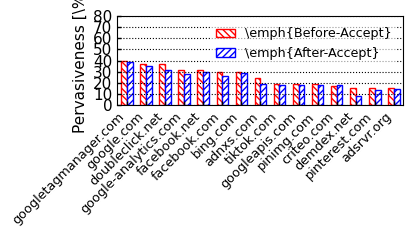

In [44]:
occ = Counter()
this_grouped = grouped [ grouped[["us"]].any(axis=1) ] 
# CHANGE THE CATEGORY HERE
cate = "Lifestyle"
this_grouped = this_grouped [ this_grouped[cate]==True ]
# We keep: Lifestyle, Jobs_and_Career, 

for s in this_grouped["tp_first"].values:
    for t in s:
        occ[t] +=1

# for s in this_grouped["trackers_first"].values:
#     for t in s:
#         occ[t] +=1
        
monitor_tp = occ.most_common(15)

plot_data = []


for tp, _ in monitor_tp:
    tot = len(this_grouped.index)
    tp_first = len(this_grouped[this_grouped["tp_first"].apply(lambda s: tp in s) ].index)
    tp_click = len(this_grouped[this_grouped["tp_click"].apply(lambda s: tp in s) ].index)  
    
    tracker_first = len(this_grouped[this_grouped["trackers_first"].apply(lambda s: tp in s) ].index)
    tracker_click = len(this_grouped[this_grouped["trackers_click"].apply(lambda s: tp in s) ].index) 

    print("1:",tp_first)
    print("2:",tp_click)
    
    plot_data.append({"tp": tp,
                  BEFORE_STR : tp_first/tot*100,
                  AFTER_STR: tp_click/tot*100,
                  BEFORE_STR + " (Tracker)": tracker_first/tot*100,
                  AFTER_STR +" (Tracker)": tracker_click/tot*100,    
                  # BEFORE_STR : tracker_first/tot*100,
                  # AFTER_STR: tracker_click/tot*100,
                 })
    
plot_df = pd.DataFrame(plot_data)
plot_df["tp"] = plot_df["tp"].replace("google.it","google.*")
plot_df.index = plot_df["tp"]
del plot_df["tp"]
plot = fastplot.plot( plot_df [[BEFORE_STR, AFTER_STR] ] ,None, 
               mode='bars_multi', ylabel = 'Pervasiveness [\\%]', xticks_rotate = 45, 
               legend = True, legend_loc='upper right', legend_ncol=1, legend_fontsize = "small", xticks_fontsize="small",
                     legend_alpha=0.6,
               grid_axis="y", yticks = ([0,10,20,30,40,50,60,70,80], None),
               ylim = (0,80), **PLOT_ARGS)

for p in plot.gca().patches[:len(plot_df)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(plot_df):]+ [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
    
N=this_grouped["sld"].nunique()
# err = plot_df[[BEFORE_STR, AFTER_STR]].applymap(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*N/100,N,0.05) ])
err = plot_df[[BEFORE_STR, AFTER_STR]].map(lambda v: [ e*100 for e in statsmodels.stats.proportion.proportion_confint(v*N/100,N,0.05) ])
# for i, tup in enumerate(err.itertuples()):
#     plot.gca().plot( (i-0.15,i-0.15), (tup[1]), linestyle="-", color="black"  )
#     plot.gca().plot( (i+0.15,i+0.15), (tup[2]), linestyle="-", color="black" )
print(f"country: {country}, category: {cate}")
plot.savefig(f"plots/category_{cate}.pdf")
plot.show()
plot_df["increase"] = plot_df[AFTER_STR] - plot_df[BEFORE_STR]
